In [1]:
# 1. Cài đặt các thư viện cần thiết
!pip install -q transformers datasets evaluate sentencepiece accelerate google-generativeai

import os
import shutil
from transformers import (
    AutoTokenizer, 
    AutoModelForSeq2SeqLM, 
    DataCollatorForSeq2Seq, 
    Seq2SeqTrainingArguments, 
    Seq2SeqTrainer
)
import evaluate
import numpy as np
from datasets import load_from_disk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 41.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.8 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

2025-11-30 09:31:32.055503: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764495092.319966      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764495092.370084      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# 1. TÌM THƯ MỤC GỐC (Nơi chứa dataset_dict.json)
INPUT_DIR = "/kaggle/input"
dataset_root_path = None

print("🔍 Đang tìm file 'dataset_dict.json'...")

for root, dirs, files in os.walk(INPUT_DIR):
    if "dataset_dict.json" in files:
        dataset_root_path = root
        print(f"✅ Đã tìm thấy gốc dataset tại: {dataset_root_path}")
        break

if not dataset_root_path:
    raise FileNotFoundError("❌ Không tìm thấy file dataset_dict.json! Hãy kiểm tra lại Input.")

# 2. COPY SANG WORKING (Bắt buộc để tránh lỗi Read-only)
# HuggingFace cần ghi file cache/lock, nên không thể load trực tiếp từ Input
WORKING_DATA_PATH = "/kaggle/working/data_ready"

if os.path.exists(WORKING_DATA_PATH):
    print(f"ℹ️ Thư mục {WORKING_DATA_PATH} đã tồn tại, đang xóa để copy mới...")
    shutil.rmtree(WORKING_DATA_PATH)

print(f"🔄 Đang copy dataset sang {WORKING_DATA_PATH}...")
shutil.copytree(dataset_root_path, WORKING_DATA_PATH)
print("✅ Copy hoàn tất!")

# 3. LOAD DATASET
print("📥 Đang load dataset...")
tokenized_datasets = load_from_disk(WORKING_DATA_PATH)

print("\n📊 CẤU TRÚC DỮ LIỆU ĐÃ LOAD:")
print(tokenized_datasets)

# Kiểm tra số lượng để em yên tâm
if 'train' in tokenized_datasets:
    print(f"   - Train: {len(tokenized_datasets['train'])} dòng")
if 'test' in tokenized_datasets:
    print(f"   - Test:  {len(tokenized_datasets['test'])} dòng")
if 'validation' in tokenized_datasets:
    print(f"   - Val:   {len(tokenized_datasets['validation'])} dòng")

🔍 Đang tìm file 'dataset_dict.json'...
✅ Đã tìm thấy gốc dataset tại: /kaggle/input/sync-dataset
🔄 Đang copy dataset sang /kaggle/working/data_ready...
✅ Copy hoàn tất!
📥 Đang load dataset...

📊 CẤU TRÚC DỮ LIỆU ĐÃ LOAD:
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 22974
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
})
   - Train: 22974 dòng
   - Test:  2000 dòng
   - Val:   2000 dòng


In [3]:
MODEL_CHECKPOINT = "VietAI/vit5-base"

# 1. Load Tokenizer & Model
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_CHECKPOINT)

# 2. Cấu hình Metric (BLEU) để đánh giá
metric = evaluate.load("bleu")

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
        
    # Giải mã (Decode) từ số về chữ
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Chuẩn bị định dạng cho BLEU
    decoded_labels = [[l] for l in decoded_labels]
    
    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    return {"bleu": result["bleu"]}

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/820k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/904M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/904M [00:00<?, ?B/s]

In [4]:
# Cấu hình tham số huấn luyện
training_args = Seq2SeqTrainingArguments(
    output_dir="/kaggle/working/vit5-finetuned",
    
    # --- HIỂN THỊ THÔNG TIN (QUAN TRỌNG) ---
    logging_strategy="steps",
    logging_steps=50,       # Cứ 50 bước (batches) sẽ in ra Loss 1 lần
    report_to="none",       # In thẳng ra màn hình
    
    # --- CHIẾN LƯỢC ĐÁNH GIÁ & LƯU ---
    eval_strategy="epoch",  # Hết 1 epoch thì đánh giá BLEU 1 lần
    save_strategy="epoch",  # Hết 1 epoch thì lưu checkpoint 1 lần
    save_total_limit=2,     # Chỉ giữ 2 checkpoint mới nhất
    
    # --- THAM SỐ TỐI ƯU ---
    learning_rate=2e-5,
    per_device_train_batch_size=16, # Tăng lên 32 nếu GPU T4 x2 chịu được
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    num_train_epochs=5,     # Train 5 vòng
    predict_with_generate=True,
    fp16=True,              # Dùng Mixed Precision
)

# Khởi tạo Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"], # Dùng tập validation để theo dõi
    tokenizer=tokenizer,
    data_collator=DataCollatorForSeq2Seq(tokenizer, model=model),
    compute_metrics=compute_metrics
)

print("🚀 BẮT ĐẦU HUẤN LUYỆN...")
print("Em hãy chú ý cột 'Training Loss' và 'Validation Loss' bên dưới nhé!")
trainer.train()

# Lưu model cuối cùng
FINAL_MODEL_PATH = "/kaggle/working/final_model"
trainer.save_model(FINAL_MODEL_PATH)
print(f"✅ Đã lưu model fine-tuned tại: {FINAL_MODEL_PATH}")

/tmp/ipykernel_47/2969066838.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


🚀 BẮT ĐẦU HUẤN LUYỆN...
Em hãy chú ý cột 'Training Loss' và 'Validation Loss' bên dưới nhé!


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Bleu
1,2.952700,2.807124,0.051592
2,2.650400,2.631080,0.068232
3,2.478300,2.551272,0.076138
4,2.357500,2.501600,0.081546
5,2.277200,2.490741,0.082920


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


✅ Đã lưu model fine-tuned tại: /kaggle/working/final_model


In [5]:
import shutil
import os
from IPython.display import FileLink, display

def save_and_download_model(model_folder_path, zip_filename="my_model_backup"):
    """
    Hàm nén thư mục model và tạo link tải về máy tính.
    
    Args:
        model_folder_path (str): Đường dẫn đến thư mục model (VD: '/kaggle/working/final_model')
        zip_filename (str): Tên file zip em muốn đặt (không cần đuôi .zip)
    """
    
    # 1. Kiểm tra xem thư mục có tồn tại không
    if not os.path.exists(model_folder_path):
        print(f"❌ Lỗi: Không tìm thấy thư mục '{model_folder_path}'")
        return

    print(f"⏳ Đang nén thư mục: {model_folder_path} ...")
    
    try:
        # 2. Nén folder thành file zip
        # root_dir: Thư mục cha, base_dir: Thư mục con cần nén
        parent_dir = os.path.dirname(model_folder_path)
        base_name = os.path.basename(model_folder_path)
        
        # Tạo file zip trong /kaggle/working/
        output_path = os.path.join("/kaggle/working", zip_filename)
        
        shutil.make_archive(
            base_name=output_path, 
            format='zip', 
            root_dir=parent_dir, 
            base_dir=base_name
        )
        
        final_zip_name = f"{zip_filename}.zip"
        
        # 3. Tạo link tải
        print(f"✅ Đã nén xong thành công: {final_zip_name}")
        print(f"👇 Bấm vào link dưới đây để tải về ngay:")
        display(FileLink(final_zip_name))
        
    except Exception as e:
        print(f"❌ Có lỗi khi nén file: {e}")

# --- CÁCH SỬ DỤNG ---

# Ví dụ: Model em lưu ở '/kaggle/working/final_model'
save_and_download_model("/kaggle/working/final_model", "sync_model_final_bai2")

# Ví dụ: Checkpoint em lưu ở '/kaggle/working/vit5-checkpoints'
# save_and_download_model("/kaggle/working/vit5-checkpoints", "checkpoint_backup")

⏳ Đang nén thư mục: /kaggle/working/final_model ...
✅ Đã nén xong thành công: sync_model_final_bai2.zip
👇 Bấm vào link dưới đây để tải về ngay:


/kaggle/working/sync_model_final_bai2.zip

Device set to use cuda:0


🔄 Đang load model...
📝 Đang phân loại và dịch mẫu...


Your input_length: 50 is bigger than 0.9 * max_length: 20. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
Your input_length: 44 is bigger than 0.9 * max_length: 20. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
Your input_length: 21 is bigger than 0.9 * max_length: 20. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
Your input_length: 60 is bigger than 0.9 * max_length: 20. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
Your input_length: 37 is bigger than 0.9 * max_length: 20. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
Your input_length: 31 is bigger than 0.9 * max_length: 20. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
You seem to be using the pipelines sequentially on GPU. In order to maximize


🩺 Bác sĩ Gemini đang khám bệnh cho 50 câu...
Câu 1 (Vi_En): [Hallucination]
Câu 2 (En_Vi): [Context]
Câu 3 (Vi_En): [Hallucination]
Câu 4 (En_Vi): [None]
Câu 5 (En_Vi): [Context]
Câu 6 (En_Vi): [Context]
Câu 7 (En_Vi): [Context]
Câu 8 (En_Vi): [Hallucination]
Câu 9 (Vi_En): [Hallucination]
Câu 10 (Vi_En): [Hallucination]
Câu 11 (En_Vi): [Hallucination]
Câu 12 (Vi_En): [Context]
Câu 13 (Vi_En): [1. None]
Câu 14 (Vi_En): [Hallucination]
Câu 15 (En_Vi): [Context]
Câu 16 (En_Vi): [Hallucination]
Câu 17 (Vi_En): [Hallucination]
Câu 18 (En_Vi): [Context]
Câu 19 (En_Vi): [Context]
Câu 20 (Vi_En): [Grammar/Structure]
Câu 21 (Vi_En): [Context]
Câu 22 (En_Vi): [Context]
Câu 23 (Vi_En): [Hallucination]
Câu 24 (Vi_En): [Hallucination]
Câu 25 (En_Vi): [Hallucination]
Câu 26 (Vi_En): [1. None]
Câu 27 (Vi_En): [Hallucination]
Câu 28 (Vi_En): [Hallucination]
Câu 29 (Vi_En): [Hallucination]
Câu 30 (En_Vi): [Context]
Câu 31 (En_Vi): [Context]
Câu 32 (Vi_En): [Hallucination]
Câu 33 (En_Vi): [Context]
Câ

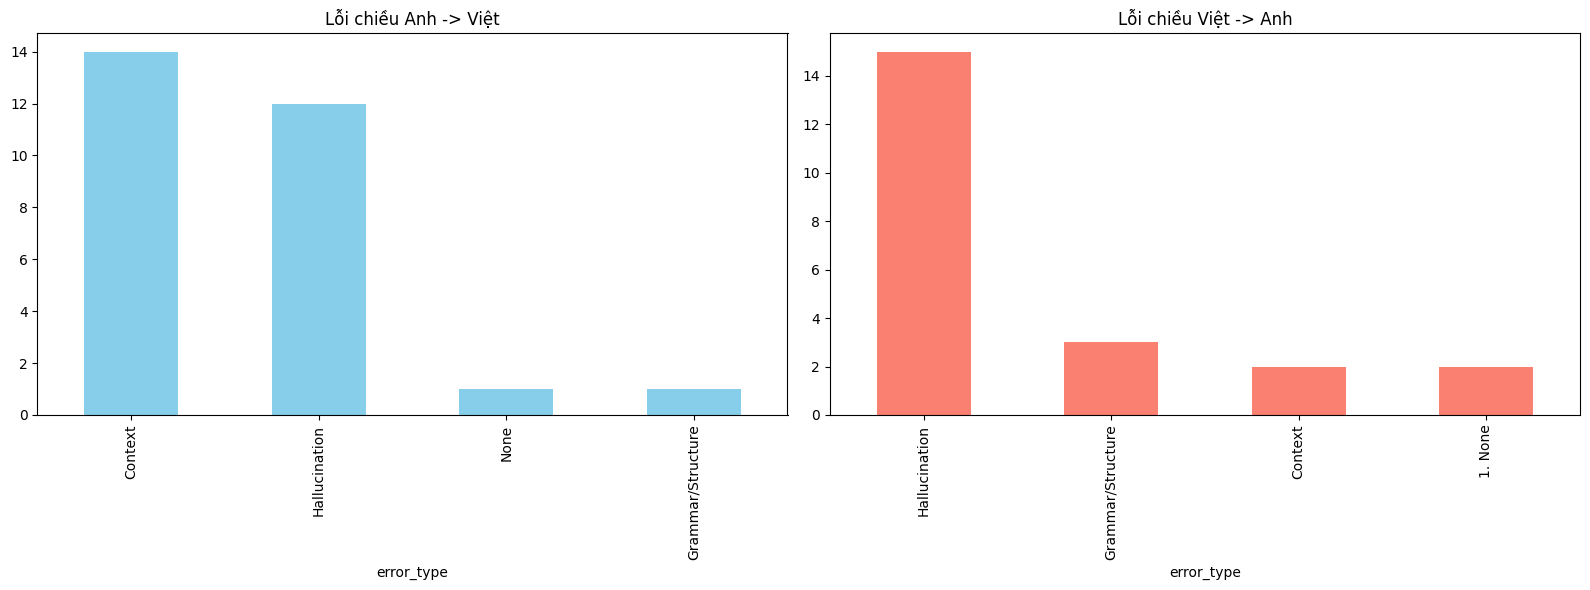


💡 NHẬN XÉT SƠ BỘ:
- Số mẫu Anh->Việt: 28
- Số mẫu Việt->Anh: 22


In [6]:
import google.generativeai as genai
from transformers import pipeline
import json
import time
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. CẤU HÌNH API ---
# (Em nhớ điền key hoặc dùng Secrets nhé)
YOUR_API_KEY = ""
genai.configure(api_key=YOUR_API_KEY)
gemini_model = genai.GenerativeModel('gemini-2.0-flash-lite-preview-02-05')

# --- 2. LOAD MODEL ---
print("🔄 Đang load model...")
translator = pipeline("translation", model=FINAL_MODEL_PATH, tokenizer=tokenizer, device=0)

# Lấy mẫu ngẫu nhiên từ tập test (đã shuffle từ trước)
test_samples = tokenized_datasets["test"].select(range(50)) 
results = []

print("📝 Đang phân loại và dịch mẫu...")

for item in test_samples:
    # 1. Decode Input để xem nó là chiều nào
    full_input_text = tokenizer.decode(item['input_ids'], skip_special_tokens=True)
    reference_text = tokenizer.decode(item['labels'], skip_special_tokens=True)
    
    # 2. Nhận diện chiều dịch dựa vào Prefix
    if "dịch Anh sang Việt:" in full_input_text:
        direction = "En_Vi"
        src_lang = "Tiếng Anh"
        tgt_lang = "Tiếng Việt"
        # Cắt bỏ prefix để lấy câu gốc sạch
        source_text = full_input_text.replace("dịch Anh sang Việt:", "").strip()
        
    elif "dịch Việt sang Anh:" in full_input_text:
        direction = "Vi_En"
        src_lang = "Tiếng Việt"
        tgt_lang = "Tiếng Anh"
        # Cắt bỏ prefix
        source_text = full_input_text.replace("dịch Việt sang Anh:", "").strip()
        
    else:
        # Trường hợp hiếm: không tìm thấy prefix (lỗi data)
        continue

    # 3. Dịch (Dùng nguyên văn input có prefix để model hiểu)
    # Lưu ý: full_input_text đã có prefix rồi
    pred = translator(full_input_text, max_new_tokens=128)[0]['translation_text']
    
    results.append({
        "direction": direction,
        "src_lang": src_lang,
        "tgt_lang": tgt_lang,
        "source": source_text,
        "ref": reference_text,
        "pred": pred
    })

# --- 3. GỬI GEMINI CHẤM ĐIỂM (THEO CHIỀU) ---
print(f"\n🩺 Bác sĩ Gemini đang khám bệnh cho {len(results)} câu...")

# Prompt linh hoạt (tự điền ngôn ngữ nguồn/đích)
diagnostic_prompt = """
Bạn là chuyên gia ngôn ngữ.
Hãy đánh giá bản dịch từ {src} sang {tgt}.

Câu gốc ({src}): "{source}"
Bản dịch mẫu ({tgt}): "{ref}"
AI dịch ({tgt}): "{pred}"

Phân tích lỗi của AI (chọn 1):
1. **None**: Dịch tốt, không có lỗi đáng kể.
2. **Rare Word**: Sai từ vựng hiếm, thuật ngữ chuyên ngành (Dataset thiếu từ vựng này).
3. **Grammar/Structure**: Sai cấu trúc ngữ pháp phức tạp (Dataset thiếu các mẫu câu đảo ngữ, câu ghép).
4. **Hallucination**: AI tự bịa ra nội dung không có trong câu gốc (Dataset có thể bị nhiễu/rác).
5. **Context**: Dịch đúng nghĩa đen nhưng sai ngữ cảnh (Dataset thiếu ngữ cảnh đa dạng).

Trả lời JSON: {{ "error_type": "...", "explanation": "..." }}
"""

diagnosis_log = []

# --- CODE ĐÁNH GIÁ ĐÃ NÂNG CẤP (FIX LỖI JSON) ---

for i, res in enumerate(results):
    # Format prompt
    prompt = diagnostic_prompt.format(
        src=res['src_lang'], 
        tgt=res['tgt_lang'],
        source=res['source'], 
        ref=res['ref'], 
        pred=res['pred']
    )
    
    try:
        # Gọi Gemini
        response = gemini_model.generate_content(prompt)
        
        # 1. KIỂM TRA SAFETY FILTER (Quan trọng)
        # Nếu bị chặn, response.text sẽ không tồn tại hoặc rỗng
        if not response.parts:
            print(f"Câu {i+1}: ⚠️ Bị Safety Filter chặn! (Bỏ qua)")
            continue

        # 2. LÀM SẠCH JSON THÔNG MINH
        raw_text = response.text.strip()
        
        # Tìm vị trí bắt đầu và kết thúc của JSON object
        start_idx = raw_text.find('{')
        end_idx = raw_text.rfind('}') + 1
        
        if start_idx != -1 and end_idx != -1:
            clean_json = raw_text[start_idx:end_idx]
            analysis = json.loads(clean_json)
            
            # Lưu kết quả
            diagnosis_log.append({
                "direction": res['direction'],
                "error_type": analysis['error_type'],
                "explanation": analysis['explanation']
            })
            
            print(f"Câu {i+1} ({res['direction']}): [{analysis['error_type']}]")
        else:
            # Trường hợp Gemini không trả về JSON
            print(f"Câu {i+1}: ❌ Lỗi format (Không tìm thấy JSON)")
            print(f"   -> Nội dung Gemini trả về: {raw_text}")

        time.sleep(1.5) 
        
    except Exception as e:
        print(f"Lỗi ngoại lệ câu {i+1}: {e}")

# --- 4. VẼ BIỂU ĐỒ SO SÁNH 2 CHIỀU ---
if diagnosis_log:
    df_diag = pd.DataFrame(diagnosis_log)
    
    # Tách ra 2 biểu đồ cho 2 chiều
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Chiều Anh -> Việt
    df_en_vi = df_diag[df_diag['direction'] == 'En_Vi']
    if not df_en_vi.empty:
        df_en_vi['error_type'].value_counts().plot(kind='bar', ax=axes[0], color='skyblue')
        axes[0].set_title('Lỗi chiều Anh -> Việt')
    
    # Chiều Việt -> Anh
    df_vi_en = df_diag[df_diag['direction'] == 'Vi_En']
    if not df_vi_en.empty:
        df_vi_en['error_type'].value_counts().plot(kind='bar', ax=axes[1], color='salmon')
        axes[1].set_title('Lỗi chiều Việt -> Anh')
        
    plt.tight_layout()
    plt.show()
    
    print("\n💡 NHẬN XÉT SƠ BỘ:")
    print(f"- Số mẫu Anh->Việt: {len(df_en_vi)}")
    print(f"- Số mẫu Việt->Anh: {len(df_vi_en)}")
else:
    print("Không có dữ liệu.")